<a href="https://colab.research.google.com/github/gettingbettersuhani/UIDAI-Project/blob/main/Enrollement_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

#Load & MERGE ALL THREE CSV FILES

In [2]:
df1 = pd.read_csv("/content/drive/MyDrive/api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv")
df3 = pd.read_csv("/content/drive/MyDrive/api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv")
df2 = pd.read_csv("/content/drive/MyDrive/api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv")

df = pd.concat([df1, df2, df3], ignore_index=True)

print("Final Shape:", df.shape)
df.head()


Final Shape: (1006029, 7)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB


In [4]:
df.isnull().sum()

,0
date,0
state,0
district,0
pincode,0
age_0_5,0
age_5_17,0
age_18_greater,0


#Convert date


In [5]:
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y")


In [6]:
df = df.drop_duplicates()

In [7]:
df.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21


#Total Enrolments

In [8]:
df["total_enrolment"] = (
    df["age_0_5"] +
    df["age_5_17"] +
    df["age_18_greater"]
)


#Monthly Aggregation (30-day level)

In [9]:
df["year_month"] = df["date"].dt.to_period("M")

monthly = (
    df.groupby(["state", "district", "year_month"])
      .agg({
          "total_enrolment": "sum",
          "age_0_5": "sum",
          "age_5_17": "sum",
          "age_18_greater": "sum"
      })
      .reset_index()
)


#Child Enrolment Ratio

In [10]:
monthly["child_enrolment_ratio"] = (
    monthly["age_0_5"] / monthly["total_enrolment"]
)


#Demographic Update Ratio

In [11]:
monthly["demographic_update_ratio"] = (
    monthly["age_5_17"] / monthly["total_enrolment"]
)


#Biometric Stress Ratio

In [12]:
monthly["biometric_update_ratio"] = (
    monthly["age_18_greater"] / monthly["total_enrolment"]
)


#UNIVARIATE RISK EXPLORATION

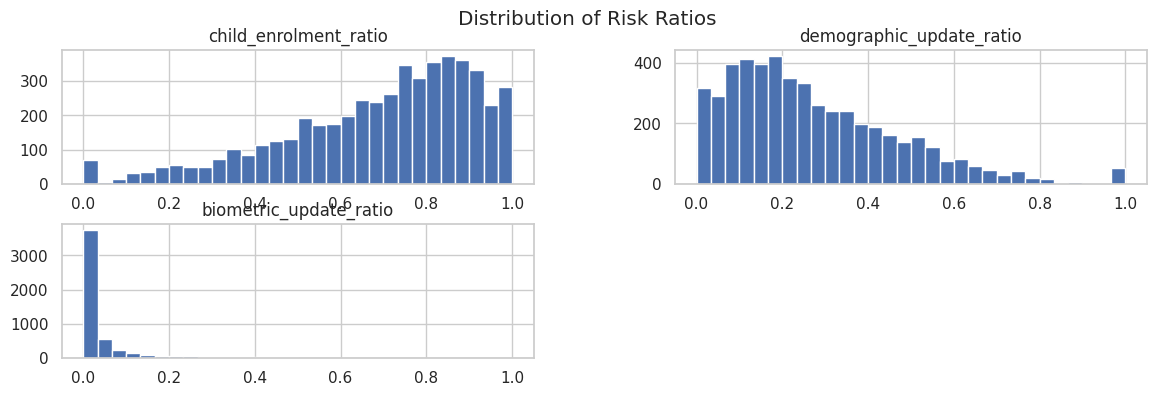

In [13]:
ratios = [
    "child_enrolment_ratio",
    "demographic_update_ratio",
    "biometric_update_ratio"
]

monthly[ratios].hist(bins=30, figsize=(14,4))
plt.suptitle("Distribution of Risk Ratios")
plt.show()


#TEMPORAL RISK EVOLUTION

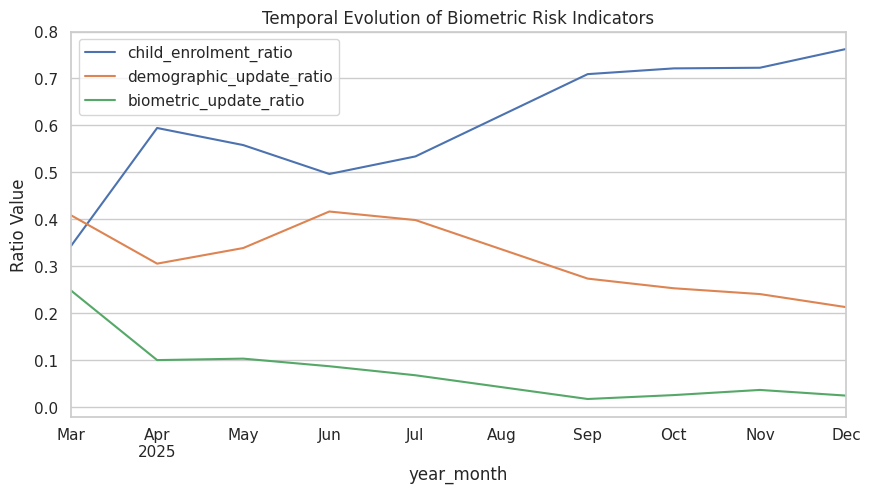

In [14]:
time_trend = (
    monthly.groupby("year_month")[ratios]
    .mean()
)

time_trend.plot()
plt.title("Temporal Evolution of Biometric Risk Indicators")
plt.ylabel("Ratio Value")
plt.show()


#REGION-WISE RISK PRESSURE

In [15]:
district_risk = (
    monthly.groupby("district")[ratios]
    .mean()
    .sort_values("child_enrolment_ratio", ascending=False)
)

district_risk.head(10)


,child_enrolment_ratio,demographic_update_ratio,biometric_update_ratio
district,,,
NADIA,1.0,0.0,0.0
North East *,1.0,0.0,0.0
Balotra,1.0,0.0,0.0
Bijapur(KAR),1.0,0.0,0.0
Udupi *,1.0,0.0,0.0
Bardez,1.0,0.0,0.0
Tiruvarur,1.0,0.0,0.0
Kendrapara *,1.0,0.0,0.0
Beawar,1.0,0.0,0.0


#COMPOSITE BIOMETRIC RISK SCORE (0–1)

In [16]:
scaler = MinMaxScaler()

scaled_ratios = scaler.fit_transform(monthly[ratios])

monthly["biometric_risk_score"] = (
    0.4 * scaled_ratios[:,0] +   # child growth
    0.3 * scaled_ratios[:,1] +   # demographic change
    0.3 * scaled_ratios[:,2]     # manual labour proxy
)


#Risk Score Distribution

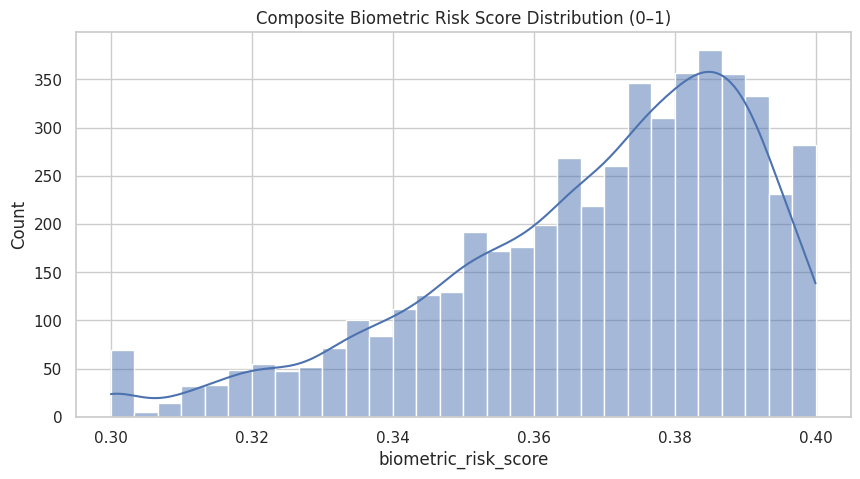

In [17]:
sns.histplot(monthly["biometric_risk_score"], bins=30, kde=True)
plt.title("Composite Biometric Risk Score Distribution (0–1)")
plt.show()


#HIGH-RISK DISTRICTS

In [18]:
high_risk_districts = (
    monthly.groupby("district")["biometric_risk_score"]
    .mean()
    .sort_values(ascending=False)
)

high_risk_districts.head(15)


,biometric_risk_score
district,
chittoor,0.4
North East *,0.4
NADIA,0.4
Bijapur(KAR),0.4
Udupi *,0.4
Bardez,0.4
Balotra,0.4
Kendrapara *,0.4
Beawar,0.4


#CORRELATION

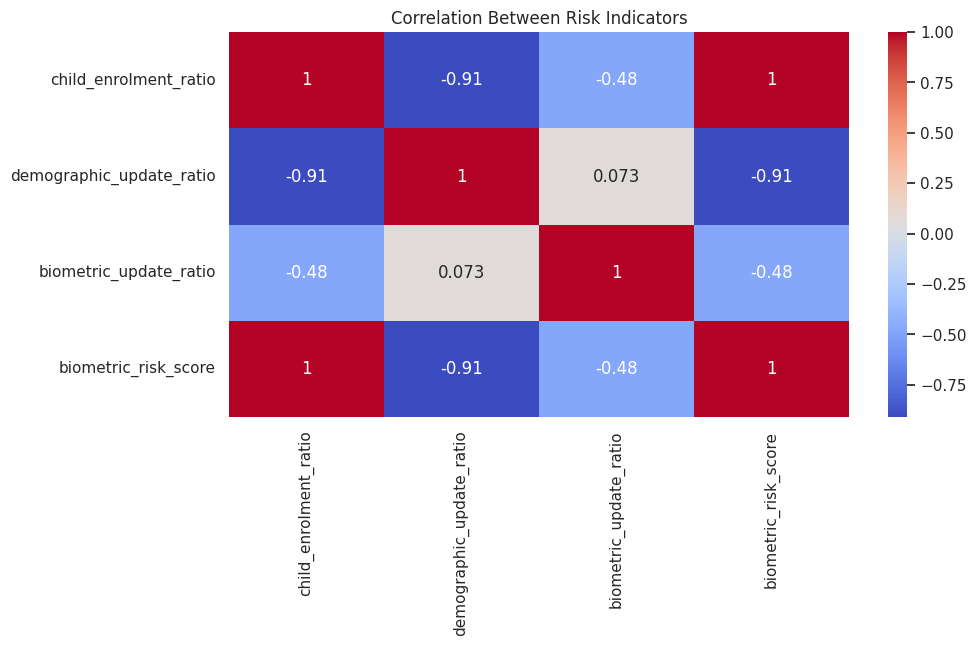

In [19]:
sns.heatmap(
    monthly[ratios + ["biometric_risk_score"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Between Risk Indicators")
plt.show()


#Final

In [20]:
monthly = monthly.sort_values(["district", "year_month"])

monthly["risk_next_month"] = (
    monthly.groupby("district")["biometric_risk_score"]
    .shift(-1)
)

model_df = monthly.dropna()

model_df.head()


,state,district,year_month,total_enrolment,age_0_5,age_5_17,age_18_greater,child_enrolment_ratio,demographic_update_ratio,biometric_update_ratio,biometric_risk_score,risk_next_month
0,100000,100000,2025-09,12,0,0,12,0.000000,0.000000,1.000000,0.300000,0.300000
1,100000,100000,2025-10,1,0,1,0,0.000000,1.000000,0.000000,0.300000,0.300000
2,100000,100000,2025-11,11,0,0,11,0.000000,0.000000,1.000000,0.300000,0.300000
4825,West Bengal,24 Paraganas North,2025-06,1050,540,399,111,0.514286,0.380000,0.105714,0.351429,0.351736
3109,Odisha,ANUGUL,2025-09,3,2,1,0,0.666667,0.333333,0.000000,0.366667,0.400000
